In [2]:
"""Load the dataset and dataset config"""
from karanir.datasets.playroom_dataset import PlayroomDataset
from torch.utils.data import DataLoader
dataset_dir = "/Users/melkor/Documents/datasets/Playroom"

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 12/22/23 10:53:15.510 1676240] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [1]:
"""Arguments or the dataset config"""
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--compute_flow",           default = False)
parser.add_argument("--precompute_flow",        default = False)
args = parser.parse_args(args = [])

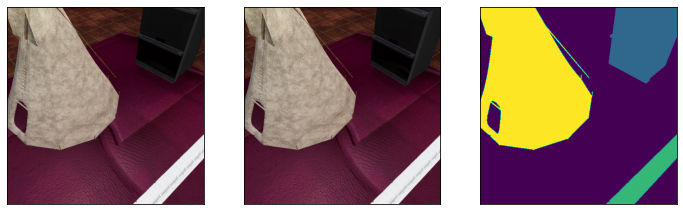

In [15]:
import matplotlib.pyplot as plt
dataset = PlayroomDataset(True, args, dataset_dir = dataset_dir, flow = False)
loader = DataLoader(dataset, batch_size = 2, shuffle = True)

for sample in loader:break;

def visualize_sample(sample, fig_name = "visualize sample", n = 12):
    fig = plt.figure(fig_name, frameon = False, figsize = (n,n * 3))
    for i,k in enumerate(sample):
        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(sample[k][0])
        plt.xticks([]);plt.yticks([]) # ignore all the label tick and just show the pics
    plt.show()

visualize_sample(sample)

In [17]:
"""Build the SceneNet that performs visual grouping with conditions"""
from karanir.thanagor.perception import SceneNet
from karanir.thanagor.model import config
scenenet = SceneNet(config)

print(scenenet)

SceneNet()
